## Import Libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# Parameters
col_indx = -1   #! 3 is meta.bias, 4 is meta.rbias, -1 means use meta.fbias from colvar_reweight file
data_path = "../../../"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"
out_dir="./"

## Load MetaD Trajectory for ADP

In [3]:
backbone_selection_101 = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

# load data
prmtopFileName =  data_path + gro_file
trajFiles = [data_path+traj_file]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("selected atom indices:", sel_backbone_101.indices)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

['../../../run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr']
1
selected atom indices: [ 4  6  8 14 16]
Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms being analyzed: 5
Number of frames being analyzed: 100001


## load phi-psi data and bias from metad sim

In [4]:
if col_indx != -1:
    time, phi, psi, bias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,col_indx), unpack=True)
else:
    # loads the final bias 
    time, phi, psi, bias = np.loadtxt(data_path+"colvar_reweight", usecols=(0,1,2,3), unpack=True)
    bias -= bias.min()

time *= 0.001  # in ns

## plot phi-psi

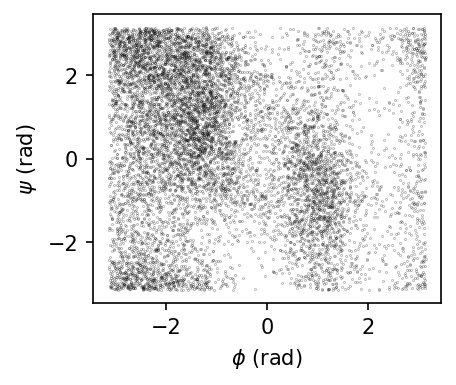

In [5]:
plt.figure(figsize=(3.0,2.5), dpi=150)
plt.xlabel("$\phi$ (rad)")
plt.ylabel("$\psi$ (rad)")
plt.scatter(phi[::10], psi[::10], marker=".", s=0.05, color='k', alpha=1.0)

## plot different choice of metad biases

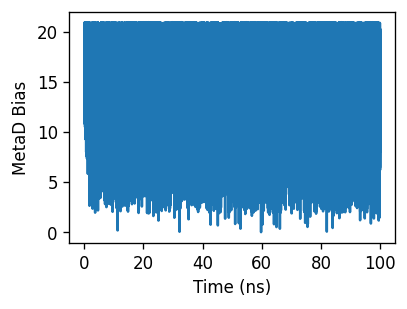

In [6]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("MetaD Bias")
plt.plot(time, bias)

## plot different weights for reweighting

In [7]:
kbt = 0.596161 # in kcal/mol @ 300K

# calculate biases
weights = np.exp(bias/kbt)
weights /= np.sum(weights)

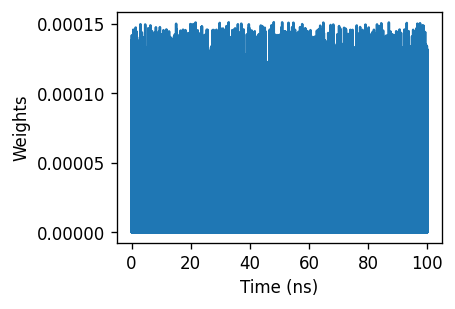

In [8]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights)

## n_clusters = 2 

In [9]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 2, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              31.813          82.234
       2              57.192          52.271
       3              53.845          76.061
       4              48.071          74.058
       5              53.849          77.727
       6              49.544          74.082
       7              53.768          75.424
       8              53.446          79.670
       9              53.816          79.759
      10              53.806          76.312
      11              54.855          59.857
      12              53.757          77.079
      13              52.907          76.997
      14              53.825          78.109
      15              53.532          78.495
      16              53.818          79.057
      17              53.817          78.984
      18              53.787          78.034
      19       

In [10]:
with open("wsgmm_2state_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [11]:
with open("wsgmm_2state_nattempts_40.pickle", "rb") as f:
    wsgmm2 = pickle.load(f)

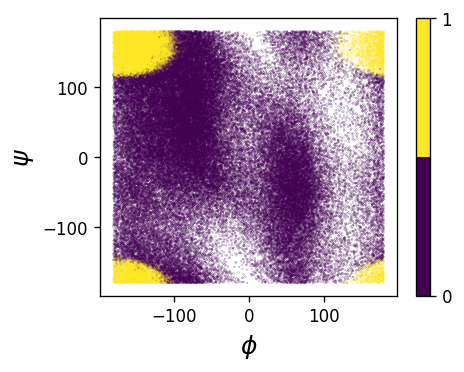

In [12]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm2.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 3 

In [13]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              55.071          92.599
       2              57.857          95.189
       3              57.482          95.021
       4              54.885          48.486
       5              57.555          75.544
       6              54.889          38.776
       7              58.098         100.130
       8              53.835          99.731
       9              57.513          93.084
      10              57.554          72.770
      11              54.856          88.529
      12              45.340          90.234
      13              57.555          71.548
      14              58.097         102.033
      15              54.888          28.161
      16              58.171          21.361
      17              53.863          65.573
      18              58.107          96.642
      19       

In [14]:
with open("wsgmm_3state_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [15]:
with open("wsgmm_3state_nattempts_40.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

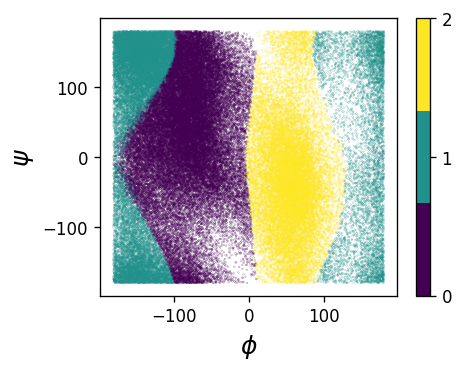

In [16]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm3.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 4 

In [17]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              58.416         109.928
       2              58.548          31.893
       3              57.503         107.714
       4              58.116         113.435
       5              57.555          74.118
       6              58.151         103.980
       7              54.820         104.683
       8              57.473         111.171
       9              57.568          63.305
      10              58.700          46.129
      11              54.865         108.418
      12              58.166          28.645
      13              57.584          34.784
      14              57.557          79.465
      15              53.698         105.454
      16              57.550          89.208
      17              57.927         108.183
      18              57.963          75.817
      19       

In [18]:
with open("wsgmm_4state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [19]:
with open("wsgmm_4state_nattempts_40.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

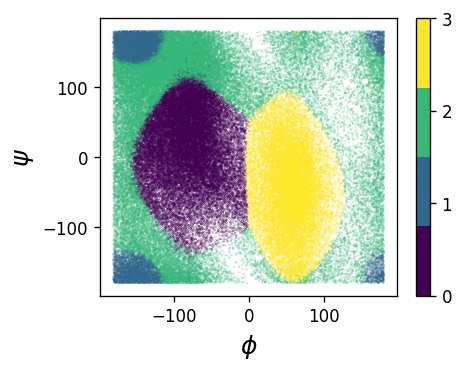

In [20]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm4.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 5 -->

In [21]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 5, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 5
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              58.049         123.154
       2              58.578          42.735
       3              57.559          99.116
       4              57.564          59.052
       5              59.201          68.213
       6              57.557         124.787
       7              58.902          32.965
       8              58.614         135.848
       9              58.170          27.180
      10              58.815         132.950
      11              58.881          53.185
      12              58.784         140.911
      13              58.594         130.295
      14              58.585         141.322
      15              54.880          58.816
      16              58.057         124.328
      17              54.871          90.547
      18              58.386          54.311
      19       

In [22]:
with open("wsgmm_5state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [23]:
with open("wsgmm_5state_nattempts_40.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

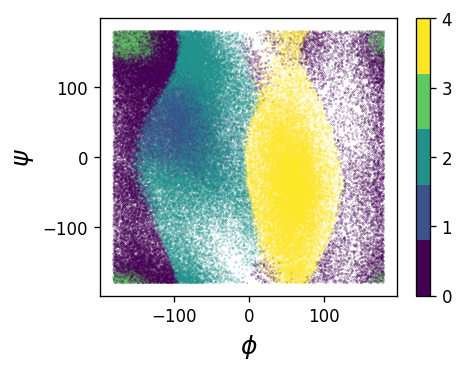

In [24]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm5.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 6 -->

In [25]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 6, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 6
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              57.484         147.968
       2              58.885          43.145
       3              58.388          64.982
       4              58.914         144.111
       5              58.700          62.265
       6              58.751         156.851
       7              59.196         155.325
       8              58.547          33.389
       9              59.545          61.306
      10              58.182          25.696
      11              57.950          50.167
      12              58.891          62.411
      13              59.049          41.477
      14              59.182         160.475
      15              59.143          42.931
      16              59.198          52.284
      17              58.882          56.311
      18              58.926          47.814
      19       

In [26]:
with open("wsgmm_6state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [27]:
with open("wsgmm_6state_nattempts_40.pickle", "rb") as f:
    wsgmm6 = pickle.load(f)

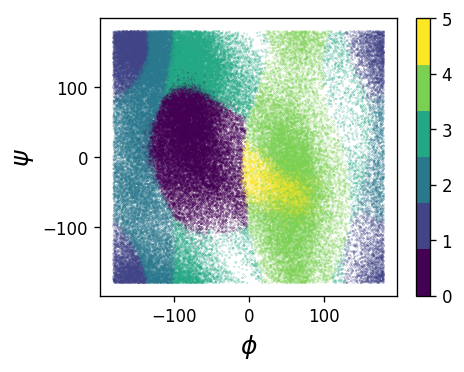

In [28]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm6.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm6.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)